In [8]:
# cd /home/daliu/Src/spykshrk_realtime/

In [9]:
cd ..

/home/droumis/Src


The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython



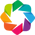

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import pandas as pd
import numpy as np
import scipy as sp

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches
import json
import os
import scipy.signal
import functools
import holoviews as hv

import math

# from spykshrk.util import AttrDict
import spykshrk.franklab.filterframework_util as ff_util

from spykshrk.realtime.simulator import nspike_data

from spykshrk.franklab.pp_decoder.util import gaussian, normal2D, apply_no_anim_boundary, simplify_pos_pandas, \
                                                normal_pdf_int_lookup
from spykshrk.franklab.pp_decoder.pp_clusterless import OfflinePPDecoder, OfflinePPEncoder
from spykshrk.franklab.pp_decoder.data_containers import EncodeSettings, DecodeSettings, SpikeObservation, \
                                                         LinearPosition, StimLockout, Posteriors, \
                                                         FlatLinearPosition, SpikeWaves, SpikeFeatures, \
                                                         pos_col_format, DayEpochTimeSeries

from spykshrk.franklab.pp_decoder.visualization import DecodeVisualizer
from spykshrk.franklab.pp_decoder.decode_error import LinearDecodeError

import dask
import dask.dataframe as dd
import dask.array as da

import cloudpickle
        
%load_ext Cython

%matplotlib inline

hv.extension('matplotlib')
hv.extension('bokeh')
#pd.set_option('float_format', '{:,.2f}'.format)
pd.set_option('display.precision', 4)
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 15)
#pd.set_option('display.width', 80)

idx = pd.IndexSlice

matplotlib.rcParams.update({'font.size': 14})

%load_ext autoreload
%autoreload 2

In [11]:
# try:
#     cluster.close()
#     client.close()
# except:
#     print("No cluster or client")
    
# from dask.distributed import Client, LocalCluster

# cluster = LocalCluster(n_workers=20, threads_per_worker=2)
# client = Client(cluster)

In [12]:
# Load merged rec HDF store based on config

#config_file = '/opt/data36/daliu/realtime/spykshrk/ripple_dec/bond.config.json'
#config_file = '/opt/data36/daliu/realtime/spykshrk/dec_60uv/bond.config.json'
# config_file = '/home/daliu/Src/spykshrk_realtime/config/bond_single.json'
config_file = '/home/droumis/Src/spykshrk_realtime/config/bond_single_derecho.json'
# config_file = '/home/droumis/Src/spykshrk_realtime/config/JZ1_derecho.json'
config = json.load(open(config_file, 'r'))

day = config['simulator']['nspike_animal_info']['days'][0]
epoch = config['simulator']['nspike_animal_info']['epochs'][0]
time_bin_size = config['pp_decoder']['bin_size']

In [13]:
# Extract just encode and decode settings from config
encode_settings = EncodeSettings(config)
decode_settings = DecodeSettings(config)

In [14]:
# Grab animal linearized real position
nspike_anim = nspike_data.AnimalInfo(**config['simulator']['nspike_animal_info'])
pos = nspike_data.PosMatDataStream(nspike_anim)
pos_data = pos.data

In [16]:
spk = nspike_data.SpkDataStream(nspike_anim)
spk_data = SpikeWaves.from_df(spk.data, encode_settings)

In [17]:
spk_data.head()

<NewCls: ee3d3d70-1cea-4af7-ba41-2bffde417d64, shape: ((5, 40))>

In [18]:
wavetest = spk_data.iloc[10:15].values

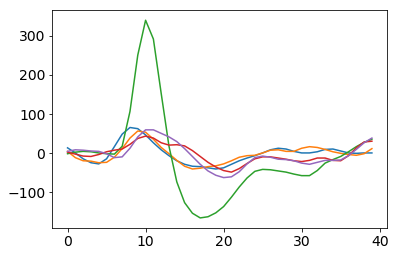

In [19]:
plt.plot(wavetest.T)

In [20]:
# Encapsulate linear position
lin_obj = LinearPosition.from_nspike_posmat(pos_data, encode_settings)
linflat_obj = lin_obj.get_mapped_single_axis()

In [21]:
linflat_obj

<FlatLinearPosition: 4f2f8caf-7961-4fa7-9346-0f030594c250, shape: ((28290, 3))>

In [22]:
lin_obj

<LinearPosition: 87785c4b-e710-4f73-89bd-606f8aa82698, shape: ((28290, 7))>

In [23]:
ripcons = nspike_data.RipplesConsData(nspike_anim)
ripdata = ripcons.data_obj

In [24]:
ripdata.head()

<NewCls: e5370d08-1b4b-4cfc-abf9-09be793f8f71, shape: ((5, 3))>

In [25]:
spk_amp = spk_data.max(axis=1)
spk_amp = spk_amp.to_frame().pivot_table(index=['day','epoch','elec_grp_id','timestamp','time'], 
                                         columns='channel', values=0)
spk_amp= SpikeFeatures(spk_amp)
spk_amp_thresh = spk_amp.get_above_threshold(60)


In [31]:
spk_amp.head()

<NewCls: ab3ac625-f2f7-41d5-895e-2a92256a2c2f, shape: ((5, 4))>

In [29]:
spk_amp_thresh.groupby('elec_grp_id')

In [93]:
linflat_obj.columns

Index(['linpos_flat', 'linvel_flat', 'seg_idx'], dtype='object')

In [88]:
linflat_obj

<FlatLinearPosition: 905b0013-9b28-4a0d-a0e7-3e9aa7a63955, shape: ((28290, 3))>

In [55]:
%%prun -r -s cumulative

encoder = OfflinePPEncoder(linflat=linflat_obj, spk_amp=spk_amp_thresh, speed_thresh=0,
                           encode_settings=encode_settings)
results = encoder.run_encoder()

In [83]:
results[0]

x000  x001  x002  x003  x004  x005  x006  ...   x443  x444  x445  x446  x447  \
day epoch elec_grp_id timestamp time                                               ...                                  
4   1     5           73831440  2,461.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   0.0   0.0   0.0   0.0   
                      73831794  2,461.1   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   0.0   0.0   0.0   0.0   
                      73832679  2,461.1   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   0.0   0.0   0.0   0.0   
                      73837524  2,461.3   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   0.0   0.0   0.0   0.0   
                      73837983  2,461.3   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   0.0   0.0   0.0   0.0   
...                                       ...   ...   ...   ...   ...   ...   ...  ...    ...   ...   ...   ...   ...   
                      102128769 3,404.3   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   0.0   0.0   0.0   0.0   
                      102130188 3,404.3   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   0.0   0.0   0.0   0.0   
                      102138393 3,404.6   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   0.0   0.0   0.0   0.0   
                      102139497 3,404.6   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   0.0   0.0   0.0   0.0   
                      102147564 3,404.9   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   0.0   0.0   0.0   0.0   

                                         x448  x449  
day epoch elec_grp_id timestamp time                 
4   1     5           73831440  2,461.0   0.0   0.0  
                      73831794  2,461.1   0.0   0.0  
                      73832679  2,461.1   0.0   0.0  
                      73837524  2,461.3   0.0   0.0  
                      73837983  2,461.3   0.0   0.0  
...                                       ...   ...  
                      102128769 3,404.3   0.0   0.0  
                      102130188 3,404.3   0.0   0.0  
                      102138393 3,404.6   0.0   0.0  
                      102139497 3,404.6   0.0   0.0  
                      102147564 3,404.9   0.0   0.0  

[18105 rows x 450 columns]

In [56]:
encode_prof = _

In [57]:
#%%time
tet_ids = np.unique(spk_amp.index.get_level_values('elec_grp_id'))
observ_tet_list = []
grp = spk_amp_thresh.groupby('elec_grp_id')
for tet_ii, (tet_id, grp_spk) in enumerate(grp):
    tet_result = results[tet_ii]
    tet_result.set_index(grp_spk.index, inplace=True)
    observ_tet_list.append(tet_result)

observ = pd.concat(observ_tet_list)
observ_obj = SpikeObservation.create_default(observ.sort_index(level=['day', 'epoch', 
                                                                      'timestamp', 'elec_grp_id']), 
                                             encode_settings.sampling_rate )

observ_obj['elec_grp_id'] = observ_obj.index.get_level_values('elec_grp_id')
observ_obj.index = observ_obj.index.droplevel('elec_grp_id')

observ_obj['position'] = (lin_obj.get_irregular_resampled(observ_obj.index.get_level_values('timestamp')).
                          get_mapped_single_axis()['linpos_flat'])

In [79]:
tet_result

x000  x001  x002  x003  x004  x005  x006  ...   x443  x444  x445  x446  x447  \
day epoch elec_grp_id timestamp time                                               ...                                  
4   1     29          73830048  2,461.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   0.0   0.0   0.0   0.0   
                      73830267  2,461.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   0.0   0.0   0.0   0.0   
                      73830735  2,461.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   0.0   0.0   0.0   0.0   
                      73831137  2,461.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   0.0   0.0   0.0   0.0   
                      73831203  2,461.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   0.0   0.0   0.0   0.0   
...                                       ...   ...   ...   ...   ...   ...   ...  ...    ...   ...   ...   ...   ...   
                      102147132 3,404.9   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   0.0   0.0   0.0   0.0   
                      102147381 3,404.9   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   0.0   0.0   0.0   0.0   
                      102147717 3,404.9   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   0.0   0.0   0.0   0.0   
                      102148872 3,405.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   0.0   0.0   0.0   0.0   
                      102149112 3,405.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   0.0   0.0   0.0   0.0   

                                         x448  x449  
day epoch elec_grp_id timestamp time                 
4   1     29          73830048  2,461.0   0.0   0.0  
                      73830267  2,461.0   0.0   0.0  
                      73830735  2,461.0   0.0   0.0  
                      73831137  2,461.0   0.0   0.0  
                      73831203  2,461.0   0.0   0.0  
...                                       ...   ...  
                      102147132 3,404.9   0.0   0.0  
                      102147381 3,404.9   0.0   0.0  
                      102147717 3,404.9   0.0   0.0  
                      102148872 3,405.0   0.0   0.0  
                      102149112 3,405.0   0.0   0.0  

[42206 rows x 450 columns]

In [80]:
observ_obj

<SpikeObservation: 297321d8-31ae-461e-9ec3-7d99c1b8294c, shape: ((303111, 456))>

In [84]:
lin_obj

<LinearPosition: c78b3b6c-34ab-4ef0-9884-e13ba1c07845, shape: ((28290, 7))>

In [58]:
%%time
# Run PP decoding algorithm
time_bin_size = 30

decoder = OfflinePPDecoder(lin_obj=lin_obj, observ_obj=observ_obj,
                           encode_settings=encode_settings, decode_settings=decode_settings, 
                           which_trans_mat='simple', time_bin_size=time_bin_size)

posteriors = decoder.run_decoder()

Beginning likelihood calculation
Beginning posterior calculation
CPU times: user 5min, sys: 3min 17s, total: 8min 18s
Wall time: 2min 24s


In [85]:
posteriors

<Posteriors: 302ee2cb-5d2e-4c12-9286-1b3df027c617, shape: ((943996, 452))>

:DynamicMap   [big_bin,small_bin]
   :Overlay
      .Curve.I   :Curve   [x]   (y)
      .Points.I  :Points   [x,y]
      .Curve.II  :Curve   [x]   (y)
      .Points.II :Points   [x,y]
      .Text.I    :Text   [x,y]
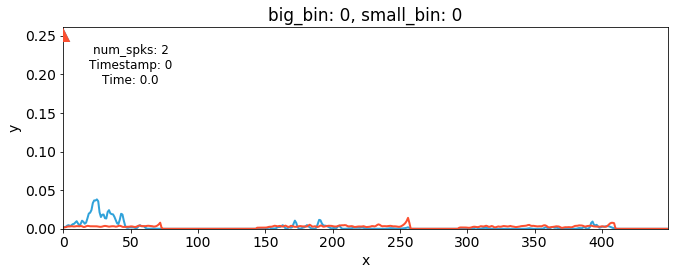

In [59]:
%%output backend='matplotlib' size=300
%%opts Points (s=200 marker='^' )
%%opts Curve [aspect=3]
%%opts Text (text_align='left')

sel_distrib = observ_obj.loc[:, pos_col_format(0,encode_settings.pos_num_bins):         
                             pos_col_format(encode_settings.pos_num_bins-1,
                                            encode_settings.pos_num_bins)]
    
sel_pos = observ_obj.loc[:, 'position']

max_prob = sel_distrib.max().max()/2

def plot_observ(big_bin, small_bin):
    bin_id = small_bin + 10000 * big_bin
    spks_in_bin = sel_distrib.loc[observ_obj['dec_bin'] == bin_id, :]
    pos_in_bin = sel_pos.loc[observ_obj['dec_bin'] == bin_id, :]
    
    num_spks = len(spks_in_bin)
    plot_list = []
    if num_spks == 0:
        plot_list.append(hv.Curve((0,[max_prob-0.01]), 
                                   extents=(0, 0, encode_settings.pos_bins[-1], max_prob)))
    for spk_observ, pos_observ in zip(spks_in_bin.values, pos_in_bin.values):
        plot_list.append(hv.Curve(spk_observ, 
                                  extents=(0, 0, encode_settings.pos_bins[-1], max_prob)))

        plot_list.append(hv.Points((pos_observ, [max_prob-0.01])))
    return hv.Overlay(plot_list) * hv.Text(50,max_prob-0.05, "num_spks: {num_spks}\n"
                                           "Timestamp: {timestamp}\nTime: {time}".
                                           format(num_spks=num_spks, timestamp=time_bin_size*bin_id,
                                                  time=time_bin_size*bin_id/30000))

#Ind = Stream.define('stuff', ind=0)

dmap = hv.DynamicMap(plot_observ, kdims=['big_bin', 'small_bin'], label="test")
#dmap = hv.DynamicMap(plot_observ, kdims=
#                     [hv.Dimension('bin_id', range=(0, observ_obj['dec_bin'].iloc[-1]), step=1)])
#dmap = hv.DynamicMap(plot_observ, kdims=
#                     [hv.Dimension('bin_id', values=observ_obj['dec_bin'].unique())])

#dmap.redim.values(bin_id=range(0, observ_obj['dec_bin'].iloc[-1]))
dmap.redim.range(small_bin=(0, 1000), big_bin=(0, observ_obj['dec_bin'].iloc[-1]/1000 + 1))
#dmap.redim.range(bin_id=(0, observ_obj['dec_bin'].iloc[-1]))
#dmap.redim.values(bin_id=[4,5])


In [60]:
%%output backend='bokeh' size=400 holomap='scrubber'
%%opts RGB { +framewise} [height=100 width=250 aspect=2 colorbar=True]
%%opts Image {+framewise} [colorbar=True]
%%opts Points {+framewise} [height=100 width=250 aspect=2 ] (marker='o' size=4 alpha=0.5)
%%opts Polygons (color='grey', alpha=0.5 fill_color='grey' fill_alpha=0.3)
dec_viz = DecodeVisualizer(posteriors, linpos=lin_obj, riptimes=ripdata, enc_settings=encode_settings)

dec_viz.plot_all_dynamic(stream=hv.streams.RangeXY(), plt_range=1, slide=1, values=ripdata['starttime']-.5)


[2475.8847994563685, 2476.8847994563685]
[3399.9167668288801, 3400.9167668288801]
[2475.8847994563685, 2476.8847994563685]


:DynamicMap   [time]
   :Overlay
      .Image.I    :Image   [time (sec),linpos (cm)]   (probability)
      .Points.I   :Points   [sec,linpos]
      .Curve.I    :Curve   [x]   (y)
      .Curve.II   :Curve   [x]   (y)
      .Curve.III  :Curve   [x]   (y)
      .Curve.IV   :Curve   [x]   (y)
      .Curve.V    :Curve   [x]   (y)
      .Curve.VI   :Curve   [x]   (y)
      .Polygons.I :Polygons   [x,y]

In [61]:
%%opts Image [height=200, width=400]
%%output size=200
dec_viz.plot_decode_image(2400, plt_range=1000)

[2461.0010000000002, 3400]


:Image   [time (sec),linpos (cm)]   (probability)

In [62]:
%%opts Image [height=200, width=400]
%%output size=200

posteriors.query('time > 3000 and time < 3001')

<NewCls: 048fcf38-6aeb-4046-bca3-d9956a08c416, shape: ((999, 452))>

In [16]:
hv.help(hv.Path)